### TD3 study

In [41]:
# RL libraries to compare to

# pip install stable-baselines3
# pip install tianshou
# pip install cleanrl
# pip install 'shimmy>=0.2.1'

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -906.42
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: -906.42 - Last mean reward per episode: -1254.54
Num timesteps: 3000
Best mean reward: -906.42 - Last mean reward per episode: -1213.68
Num timesteps: 4000
Best mean reward: -906.42 - Last mean reward per episode: -1173.43
Num timesteps: 5000
Best mean reward: -906.42 - Last mean reward per episode: -1290.58
Num timesteps: 6000
Best mean reward: -906.42 - Last mean reward per episode: -1376.47
Num timesteps: 7000
Best mean reward: -906.42 - Last mean reward per episode: -1077.37
Num timesteps: 8000
Best mean reward: -906.42 - Last mean reward per episode: -828.63
Saving new best model to tmp/best_model
Num timesteps: 9000
Best mean reward: -828.63 - Last mean reward per episode: -691.90
Saving new best model to tmp/best_model
Num timesteps: 10000
Best mean reward: -691.90 - Last mean reward per episode: -599.21
Saving new best 

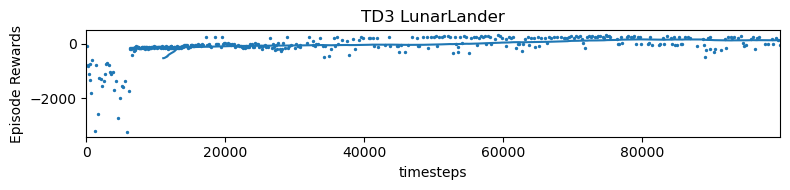

In [3]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, log_dir)

# Add some action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Train the agent
timesteps = 1e5
model.learn(total_timesteps=int(timesteps), callback=callback)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()

